In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from typing import List, Tuple, Dict, Optional
import gym
from gym import spaces
from scipy import ndimage

class WoodCuttingEnv(gym.Env):
    def __init__(self, big_platform_size=(100, 100), max_platforms=5):
        super(WoodCuttingEnv, self).__init__()
        
        # Initialize with the size of big wood platforms
        self.big_platform_width, self.big_platform_height = big_platform_size
        self.max_platforms = max_platforms
        
        # State: Representation of the current platform's state
        # We'll represent it as a binary grid
        self.grid_size = 100  # We'll use a 100x100 grid for simplicity
        

        #################################################################################
        # Track piece types in each position (0 = empty, 1+ = piece type index + 1)
        self.platforms = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]
        self.piece_types = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]
        #################################################################################


        # State space: Current platform's grid state + remaining order pieces + current platform index
        grid_space = spaces.Box(low=0, high=1, shape=(self.grid_size, self.grid_size), dtype=np.int8)
        
        # Max number of different piece types in an order
        self.max_order_types = 10
        # Order space: (width, height, quantity) for each order type
        order_space = spaces.Box(
            low=np.array([[1, 1, 0]] * self.max_order_types),
            high=np.array([[self.big_platform_width, self.big_platform_height, 100]] * self.max_order_types),
            dtype=np.int32
        )
        
        # Current platform index
        platform_index_space = spaces.Discrete(self.max_platforms + 1)  # +1 for "no platforms left"
        
        # Combine spaces
        self.observation_space = spaces.Dict({
            'grid': grid_space,
            'order': order_space,
            'platform_index': platform_index_space
        })
        
        # Action space: (x, y, piece_type, rotation)
        # x, y: position to place the piece
        # piece_type: which piece type from the order to use
        # rotation: 0 or 1 (0° or 90°)
        self.action_space = spaces.MultiDiscrete([
            self.grid_size,  # x
            self.grid_size,  # y
            self.max_order_types,  # piece_type
            2  # rotation (0 or 1)
        ])
        
        # Initialize state
        self.reset()
    
    def reset(self, order=None):
        """Reset environment with a new or provided order."""

        #################################################################################
        # Initialize the first platform grid (0 = empty, 1 = filled)
        self.platforms = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]
        self.piece_types = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]
        #################################################################################

        # # Initialize the first platform grid (0 = empty, 1 = filled)
        # self.platforms = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]

        self.current_platform_idx = 0
        
        
        # Generate a random order if none provided
        if order is None:
            self.order = self._generate_random_order()
        else:
            self.order = order.copy()
        
        return self._get_observation()
    
    def _generate_random_order(self):
        """Generate a random cutting order."""
        num_types = np.random.randint(1, self.max_order_types + 1)
        order = []
        
        for _ in range(num_types):
            width = np.random.randint(5, min(self.big_platform_width // 2, 30) + 1)
            height = np.random.randint(5, min(self.big_platform_height // 2, 30) + 1)
            quantity = np.random.randint(1, 20)
            order.append([width, height, quantity])
        
        # Pad the order to max_order_types
        while len(order) < self.max_order_types:
            order.append([0, 0, 0])
            
        return np.array(order)
    
    def _get_observation(self):
        """Return the current observation."""
        return {
            'grid': self.platforms[self.current_platform_idx],
            'order': self.order,
            'platform_index': self.current_platform_idx
        }
    
    def _is_valid_placement(self, x, y, piece_width, piece_height, platform_idx=None):
        """Check if a piece can be placed at (x, y) with given dimensions."""
        if platform_idx is None:
            platform_idx = self.current_platform_idx
            
        if x + piece_width > self.grid_size or y + piece_height > self.grid_size:
            return False
        
        # Check if the area is empty
        if np.any(self.platforms[platform_idx][y:y+piece_height, x:x+piece_width] == 1):
            return False
        
        return True
    
    def _can_fit_anywhere(self, piece_width, piece_height, platform_idx=None):
        """Check if a piece can fit anywhere on the specified platform."""
        if platform_idx is None:
            platform_idx = self.current_platform_idx
            
        for y in range(self.grid_size - piece_height + 1):
            for x in range(self.grid_size - piece_width + 1):
                if self._is_valid_placement(x, y, piece_width, piece_height, platform_idx):
                    return True, (x, y)
        return False, None
    
    #################################################################################
    def _place_piece(self, x, y, piece_width, piece_height, piece_type, platform_idx=None):
    #################################################################################
    # def _place_piece(self, x, y, piece_width, piece_height, platform_idx=None):
        """Place a piece at (x, y) with given dimensions."""
        if platform_idx is None:
            platform_idx = self.current_platform_idx
            
        self.platforms[platform_idx][y:y+piece_height, x:x+piece_width] = 1

        #################################################################################
        self.piece_types[platform_idx][y:y+piece_height, x:x+piece_width] = piece_type + 1  # +1 to avoid 0
        #################################################################################

    def step(self, action):
        """
        Take a step in the environment.
        
        Args:
            action: [x, y, piece_type, rotation]
        
        Returns:
            observation, reward, done, info
        """
        x, y, piece_type, rotation = action
        
        # Check if piece_type is valid
        if piece_type >= len(self.order) or self.order[piece_type][2] <= 0:
            # Invalid piece type or no more pieces of this type
            return self._get_observation(), -10, False, {'message': 'Invalid piece type'}
        
        # Get piece dimensions
        width, height, quantity = self.order[piece_type]
        
        # Apply rotation if needed
        if rotation == 1:
            width, height = height, width
        
        # Check if placement is valid at the chosen position on the current platform
        if not self._is_valid_placement(x, y, width, height):
            # Try to find placement on any existing platform
            placed = False
            best_position = None
            best_platform = None
            
            # Check all existing platforms
            for platform_idx in range(len(self.platforms)):
                can_fit, new_pos = self._can_fit_anywhere(width, height, platform_idx)
                if can_fit:
                    if best_position is None or platform_idx <= best_platform:
                        best_position = new_pos
                        best_platform = platform_idx
                        placed = True
            
            if placed:
                # Place at the best position found
                x, y = best_position
                self._place_piece(x, y, width, height, piece_type, best_platform)
                self.order[piece_type][2] -= 1
                # Set the current platform to where we placed the piece
                self.current_platform_idx = best_platform
                reward = width * height - 5  # Small penalty for repositioning
            else:
                # Try creating a new platform if allowed
                if self.current_platform_idx + 1 < self.max_platforms:
                    new_platform_idx = len(self.platforms)
                    self.platforms.append(np.zeros((self.grid_size, self.grid_size), dtype=np.int8))
                    self.piece_types.append(np.zeros((self.grid_size, self.grid_size), dtype=np.int8))
                    
                    # Place at the beginning of the new platform
                    if self._is_valid_placement(0, 0, width, height, new_platform_idx):
                        self._place_piece(0, 0, width, height, piece_type, new_platform_idx)
                        self.order[piece_type][2] -= 1
                        self.current_platform_idx = new_platform_idx
                        reward = width * height - 50  # Reward for successful placement minus penalty for new platform
                    else:
                        reward = -20  # Penalty for invalid placement even on new platform
                else:
                    reward = -30  # No more platforms available
                    return self._get_observation(), reward, True, {'message': 'No more platforms'}
        else:
            # Place the piece at the original position on current platform
            self._place_piece(x, y, width, height, piece_type)
            self.order[piece_type][2] -= 1
            reward = width * height  # Reward proportional to the piece area
        
        # Check if all pieces have been placed
        done = np.all(self.order[:, 2] == 0)
        
        # Calculate total waste (empty space) on used platforms
        if done:
            total_area = self.big_platform_width * self.big_platform_height * len(self.platforms)
            filled_area = sum(np.sum(platform) for platform in self.platforms)
            waste = total_area - filled_area
            efficiency = filled_area / total_area
            
            # Add final reward based on efficiency
            reward += efficiency * 1000
            
            return self._get_observation(), reward, done, {
                'message': 'All pieces placed',
                'waste': waste,
                'efficiency': efficiency,
                'platforms_used': len(self.platforms)
            }
        
        return self._get_observation(), reward, done, {}
    
    def render(self):
        # """Render the current state of the environment."""
        """Render the current state of the environment with different colors for each piece type."""
        piece_colors = ['white', 'red', 'blue', 'green', 'purple', 'orange', 'yellow', 'black', 'gray', 'pink', 'brown']

        #################################################################################

        fig, axs = plt.subplots(1, len(self.platforms), figsize=(5*len(self.platforms), 5))
        if len(self.platforms) == 1:
            axs = [axs]
        
        for i, platform in enumerate(self.platforms):
            ax = axs[i]
            
            # Create a colored image
            colored_image = np.zeros((self.grid_size, self.grid_size, 3))
            
            # Fill with colors based on piece types
            for y in range(self.grid_size):
                for x in range(self.grid_size):
                    piece_type = self.piece_types[i][y, x]
                    if piece_type > 0:
                        # Convert color name to RGB
                        color_name = piece_colors[piece_type]
                        color_rgb = np.array(plt.matplotlib.colors.to_rgb(color_name))
                        colored_image[y, x] = color_rgb
            
            ax.imshow(colored_image)
            ax.set_title(f'Platform {i+1}')
            ax.set_xlim(0, self.grid_size)
            ax.set_ylim(0, self.grid_size)
            ax.invert_yaxis()  # Invert y-axis to match grid coordinates
            
            # Draw grid lines
            # Add grid lines (optional, for clarity)
            ax.set_xticks(np.arange(-.5, self.grid_size, 10))
            ax.set_yticks(np.arange(-.5, self.grid_size, 10))
            ax.grid(True, color='black', linewidth=0.5, alpha=0.3)
            
            # Add piece outlines
            for type_id in range(1, self.max_order_types + 1):
                piece_mask = (self.piece_types[i] == type_id)
                if not np.any(piece_mask):
                    continue
                    
                # Find connected components
                labeled, num_features = ndimage.label(piece_mask)
                
                for feature in range(1, num_features + 1):
                    feature_mask = (labeled == feature)
                    
                    # Get the bounds of this feature
                    ys, xs = np.where(feature_mask)
                    x_min, x_max = np.min(xs), np.max(xs)
                    y_min, y_max = np.min(ys), np.max(ys)
                    
                    # Draw rectangle around the piece
                    rect = patches.Rectangle(
                        (x_min - 0.5, y_min - 0.5), 
                        x_max - x_min + 1, 
                        y_max - y_min + 1, 
                        linewidth=2, 
                        edgecolor='black', 
                        facecolor='none'
                    )
                    ax.add_patch(rect)
        
        # Display remaining order with colors
        order_text = []
        for idx, (w, h, q) in enumerate(self.order):
            if q > 0:
                color = piece_colors[idx + 1]
                order_text.append(f"<span style='color:{color}'>{w}x{h} (qty: {q})</span>")
        
        if order_text:
            from matplotlib.text import Text
            plt.figtext(0.5, 0.01, f"Remaining pieces: {', '.join(order_text)}", 
                    ha="center", fontsize=9, bbox={"facecolor":"white", "alpha":0.8})
        else:
            plt.figtext(0.5, 0.01, "All pieces placed!", ha="center", fontsize=9, 
                    bbox={"facecolor":"green", "alpha":0.5})
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()
    def close(self):
        plt.close('all')

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import random

class ActorCriticNetwork(nn.Module):
    def __init__(self, input_shape, action_dims):
        super(ActorCriticNetwork, self).__init__()
        
        # CNN for processing the grid
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        
        # Calculate the size after convolutions
        def conv2d_size_out(size, kernel_size=3, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        conv_width = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 5, 2)))
        conv_height = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[0], 5, 2)))
        linear_input_size = conv_width * conv_height * 64
        
        # FC for processing the order information
        self.fc_order = nn.Linear(30, 128)  # 10 order types x 3 features (width, height, quantity)
        
        # FC for processing platform index
        self.fc_platform = nn.Linear(1, 32)
        
        # Combine and process
        self.fc_combine = nn.Linear(linear_input_size + 128 + 32, 512)
        
        # Actor head (policy)
        self.actor_x = nn.Linear(512, action_dims[0])  # x position
        self.actor_y = nn.Linear(512, action_dims[1])  # y position
        self.actor_piece = nn.Linear(512, action_dims[2])  # piece type
        self.actor_rotation = nn.Linear(512, action_dims[3])  # rotation
        
        # Critic head (value function)
        self.critic = nn.Linear(512, 1)
        
    def forward(self, grid, order, platform_idx):
        # Process grid
        grid = grid.unsqueeze(1)  # Add channel dimension
        grid = F.relu(self.conv1(grid))
        grid = F.relu(self.conv2(grid))
        grid = F.relu(self.conv3(grid))
        grid = grid.view(grid.size(0), -1)  # Flatten
        
        # Process order
        order = order.view(order.size(0), -1)  # Flatten
        order = F.relu(self.fc_order(order))
        
        # Process platform index
        platform_idx = platform_idx.float().view(-1, 1)
        platform = F.relu(self.fc_platform(platform_idx))
        
        # Combine
        combined = torch.cat((grid, order, platform), dim=1)
        features = F.relu(self.fc_combine(combined))
        
        # Actor outputs (policy distributions)
        x_logits = self.actor_x(features)
        y_logits = self.actor_y(features)
        piece_logits = self.actor_piece(features)
        rotation_logits = self.actor_rotation(features)
        
        # Critic output (value function)
        value = self.critic(features)
        
        return x_logits, y_logits, piece_logits, rotation_logits, value

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []
        self.batch_size = batch_size
        
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear_memory(self):
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []
    
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        
        return batches

class PPOAgent:
    def __init__(self, state_shape, action_space, device="cuda" if torch.cuda.is_available() else "cpu",
                 lr=0.0003, gamma=0.99, gae_lambda=0.95, policy_clip=0.2, 
                 batch_size=64, n_epochs=10, entropy_coefficient=0.01):
        self.state_shape = state_shape
        self.action_space = action_space
        self.device = device
        
        # PPO hyperparameters
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.entropy_coefficient = entropy_coefficient
        
        # Create actor-critic network
        self.actor_critic = ActorCriticNetwork(
            input_shape=(state_shape['grid'][0], state_shape['grid'][1]),
            action_dims=(action_space[0], action_space[1], action_space[2], action_space[3])
        ).to(device)
        
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        self.memory = PPOMemory(batch_size)
        
        # For handling actions
        self.grid_size = state_shape['grid'][0]
        self.max_order_types = state_shape['order'][0]
        self.rotations = action_space[3]
        
    def choose_action(self, state, training=True):
        # Convert state to tensors
        grid = torch.FloatTensor(state['grid']).unsqueeze(0).to(self.device)
        order = torch.FloatTensor(state['order']).unsqueeze(0).to(self.device)
        platform_idx = torch.LongTensor([state['platform_index']]).to(self.device)
        
        # Get action distributions and value from actor-critic
        with torch.no_grad():
            x_logits, y_logits, piece_logits, rotation_logits, value = self.actor_critic(
                grid, order, platform_idx
            )
        
        # Create distributions for each action component
        x_dist = Categorical(F.softmax(x_logits, dim=1))
        y_dist = Categorical(F.softmax(y_logits, dim=1))
        
        # Mask invalid piece types (pieces with quantity 0)
        piece_mask = torch.ones_like(piece_logits) * float('-inf')
        for i, (_, _, qty) in enumerate(state['order']):
            if qty > 0:
                piece_mask[0, i] = 0  # Unmask valid piece types
        
        masked_piece_logits = piece_logits + piece_mask
        piece_dist = Categorical(F.softmax(masked_piece_logits, dim=1))
        rotation_dist = Categorical(F.softmax(rotation_logits, dim=1))
        
        # Sample actions from distributions (or take most likely action during evaluation)
        if training:
            x = x_dist.sample()
            y = y_dist.sample()
            piece_type = piece_dist.sample()
            rotation = rotation_dist.sample()
        else:
            x = torch.argmax(x_dist.probs)
            y = torch.argmax(y_dist.probs)
            piece_type = torch.argmax(piece_dist.probs)
            rotation = torch.argmax(rotation_dist.probs)
        
        # Calculate log probabilities
        x_prob = x_dist.log_prob(x)
        y_prob = y_dist.log_prob(y)
        piece_prob = piece_dist.log_prob(piece_type)
        rotation_prob = rotation_dist.log_prob(rotation)
        
        # Sum the log probs to get the total action log probability
        action_log_prob = x_prob + y_prob + piece_prob + rotation_prob
        
        return [x.item(), y.item(), piece_type.item(), rotation.item()], action_log_prob.item(), value.item()
    
    def store_transition(self, state, action, action_log_prob, value, reward, done):
        self.memory.store_memory(state, action, action_log_prob, value, reward, done)
    
    def learn(self):
        for _ in range(self.n_epochs):
            # Calculate advantages and returns
            state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, done_arr = self._process_memory()
            
            # Generate mini-batches
            batches = self.memory.generate_batches()
            
            # Train on each batch
            for batch in batches:
                # Select batch components
                grids = torch.FloatTensor(state_arr['grid'][batch]).to(self.device)
                orders = torch.FloatTensor(state_arr['order'][batch]).to(self.device)
                platform_idxs = torch.LongTensor(state_arr['platform_index'][batch]).to(self.device)
                
                actions = action_arr[batch]
                old_probs = old_prob_arr[batch]
                values = vals_arr[batch]
                
                # Calculate advantages and returns for the batch
                advantages = self._calculate_advantages(
                    reward_arr[batch], values, done_arr[batch]
                )
                returns = advantages + values
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
                # Forward pass
                x_logits, y_logits, piece_logits, rotation_logits, critic_value = self.actor_critic(
                    grids, orders, platform_idxs
                )
                
                # Extract action components
                x = actions[:, 0]
                y = actions[:, 1]
                piece_type = actions[:, 2]
                rotation = actions[:, 3]
                
                # Create distributions
                x_dist = Categorical(F.softmax(x_logits, dim=1))
                y_dist = Categorical(F.softmax(y_logits, dim=1))
                piece_dist = Categorical(F.softmax(piece_logits, dim=1))
                rotation_dist = Categorical(F.softmax(rotation_logits, dim=1))
                
                # Calculate new log probabilities
                x_new_probs = x_dist.log_prob(torch.LongTensor(x).to(self.device))
                y_new_probs = y_dist.log_prob(torch.LongTensor(y).to(self.device))
                piece_new_probs = piece_dist.log_prob(torch.LongTensor(piece_type).to(self.device))
                rotation_new_probs = rotation_dist.log_prob(torch.LongTensor(rotation).to(self.device))
                
                # Combine log probabilities
                new_probs = x_new_probs + y_new_probs + piece_new_probs + rotation_new_probs
                
                # Calculate probability ratio
                prob_ratio = torch.exp(new_probs - torch.FloatTensor(old_probs).to(self.device))
                
                # Calculate surrogate losses
                weighted_probs = advantages.to(self.device) * prob_ratio
                weighted_clipped_probs = advantages.to(self.device) * torch.clamp(
                    prob_ratio, 1-self.policy_clip, 1+self.policy_clip
                )
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()
                
                # Add entropy bonus for exploration
                entropy = x_dist.entropy().mean() + y_dist.entropy().mean() + \
                        piece_dist.entropy().mean() + rotation_dist.entropy().mean()
                
                # Calculate critic loss
                returns = returns.float().to(self.device)  # Ensure returns is float32
                critic_loss = F.mse_loss(critic_value.squeeze(), returns)
                
                # Calculate total loss
                total_loss = actor_loss + 0.5 * critic_loss - self.entropy_coefficient * entropy
                
                # Update network
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()
        
        # Clear memory after learning
        self.memory.clear_memory()

    def _calculate_advantages(self, rewards, values, dones):
        """Calculate advantages using Generalized Advantage Estimation (GAE)."""
        advantages = np.zeros_like(rewards)
        gae = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[t + 1]
            
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
            advantages[t] = gae
        
        return torch.tensor(advantages, dtype=torch.float32)  # Explicitly use float32
    
    def _process_memory(self):
        """Process memory data into arrays."""
        # States need special handling due to being dictionaries
        state_arr = {
            'grid': [],
            'order': [],
            'platform_index': []
        }
        
        for state in self.memory.states:
            state_arr['grid'].append(state['grid'])
            state_arr['order'].append(state['order'])
            state_arr['platform_index'].append(state['platform_index'])
        
        # Convert states to numpy arrays
        state_arr = {k: np.array(v) for k, v in state_arr.items()}
        
        # Convert other memory components to numpy arrays
        action_arr = np.array(self.memory.actions)
        old_prob_arr = np.array(self.memory.probs)
        vals_arr = np.array(self.memory.vals)
        reward_arr = np.array(self.memory.rewards)
        done_arr = np.array(self.memory.dones)
        
        return state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, done_arr
    
    def _calculate_advantages(self, rewards, values, dones):
        """Calculate advantages using Generalized Advantage Estimation (GAE)."""
        advantages = np.zeros_like(rewards)
        gae = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[t + 1]
            
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
            advantages[t] = gae
        
        return torch.FloatTensor(advantages)
    
    def save_model(self, path):
        torch.save({
            'actor_critic': self.actor_critic.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }, path)
    
    def load_model(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.actor_critic.load_state_dict(checkpoint['actor_critic'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])

/home/viettiev/projects/REL301m/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
def custom_order_example():
    """Example of using a custom order with PPO agent."""
    # Create environment
    env = WoodCuttingEnv()
    
    # Create and load agent
    agent = PPOAgent(
        state_shape={
            'grid': env.observation_space['grid'].shape,
            'order': env.observation_space['order'].shape,
            'platform_index': (1,)
        },
        action_space=env.action_space.nvec
    )
    
    try:
        # agent.load_model('models/ppo_wood_cutting_final.pth')
        agent.load_model(r'/home/viettiev/projects/REL301m/my_assignment/PPO/models/ppo_wood_cutting_final.pth')
        print("Loaded trained model")
    except:
        print("No trained model found, using untrained agent")
    
    # You can define your custom order here
    # custom_order = np.array([
    #     [40, 30, 6],    # 6 pieces of 40x30  
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0]      # Padding
    # ])
    custom_order = np.array([
        [40, 40, 1],   # 1 pieces of 40x40  
        [60, 60, 2],   # 2 pieces of 60x60  
        [40, 30, 10],  # 10 pieces of 40x30  
        [20, 10, 9],   # 9 pieces of 20x10  
        [0, 0, 0],     # Padding
        [0, 0, 0],     # Padding
        [0, 0, 0],     # Padding
        [0, 0, 0],     # Padding
        [0, 0, 0],     # Padding
        [0, 0, 0]      # Padding
    ])
    
    
    # Reset environment with custom order
    state = env.reset(order=custom_order)
    
    # Run episode with custom order
    done = False
    total_reward = 0
    steps = 0
    max_steps = 200
    print('current_step: ',steps)
    env.render()
    
    print("Starting custom order optimization with PPO...")
    
    while not done and steps < max_steps:
        # Choose action
        action, _, _ = agent.choose_action(state, training=False)
        
        # Take action
        next_state, reward, done, info = env.step(action)
        
        # Update state and total reward
        state = next_state
        total_reward += reward
        steps += 1
        print('current_step: ',steps)
        env.render()
        if done:
            print(f"Order completed in {steps} steps")
            print(f"Total reward: {total_reward:.2f}")
            if 'waste' in info:
                print(f"Waste: {info['waste']}")
                print(f"Efficiency: {info['efficiency']:.2f}")
                print(f"Platforms used: {info['platforms_used']}")
    
    # Render final state
    print('current_step: ',steps)
    env.render()
    
    if not done:
        print(f"Failed to complete order within {max_steps} steps")
    
    return total_reward

Loaded trained model
current_step:  0


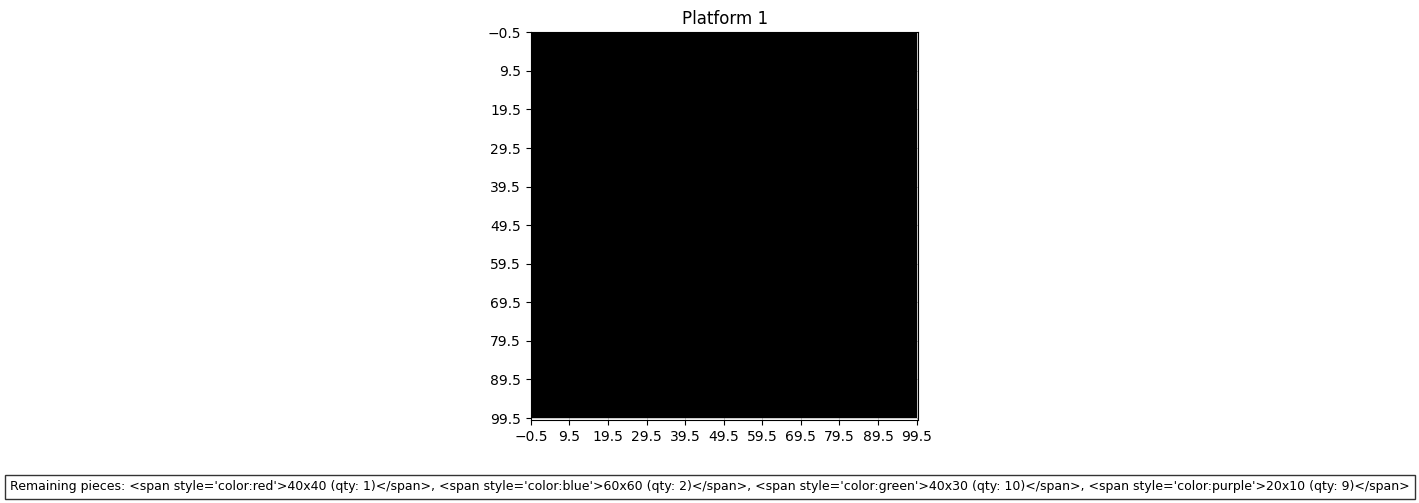

Starting custom order optimization with PPO...
current_step:  1


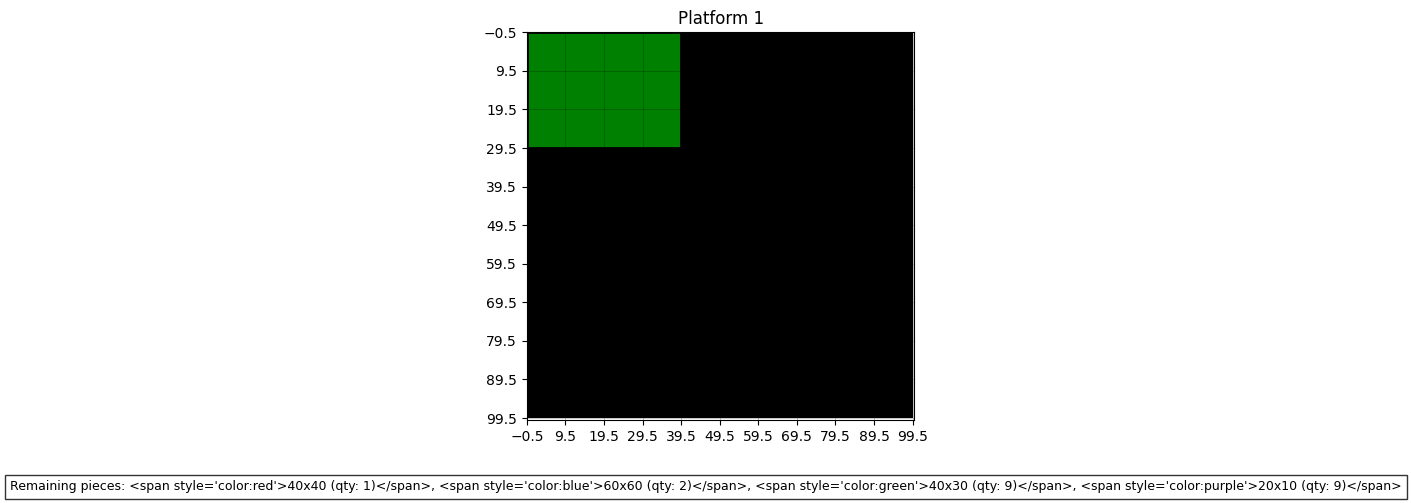

current_step:  2


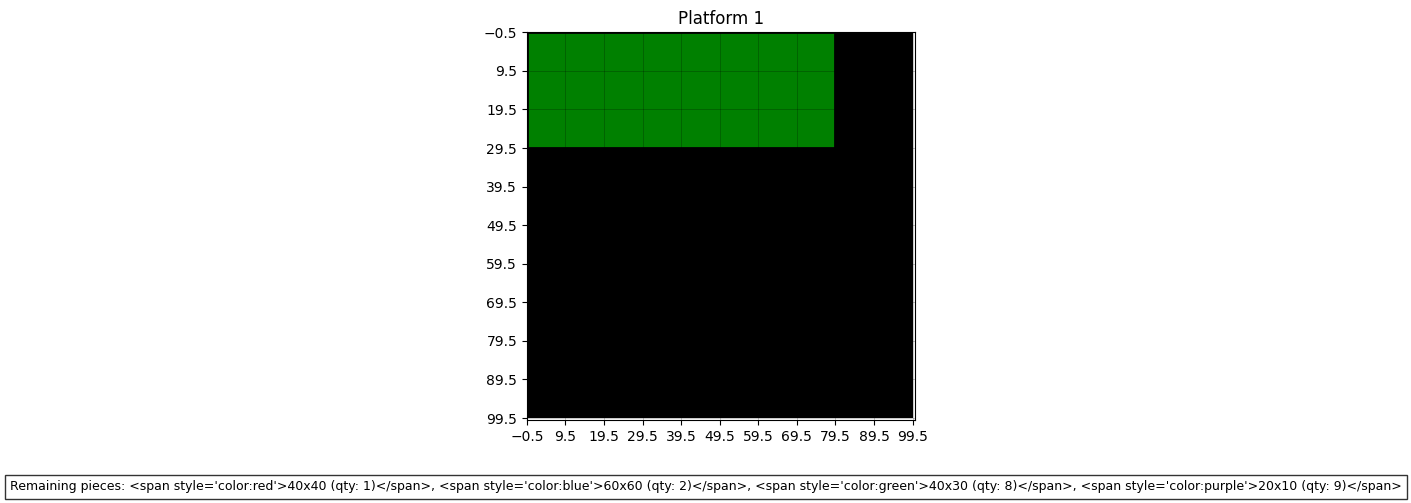

current_step:  3


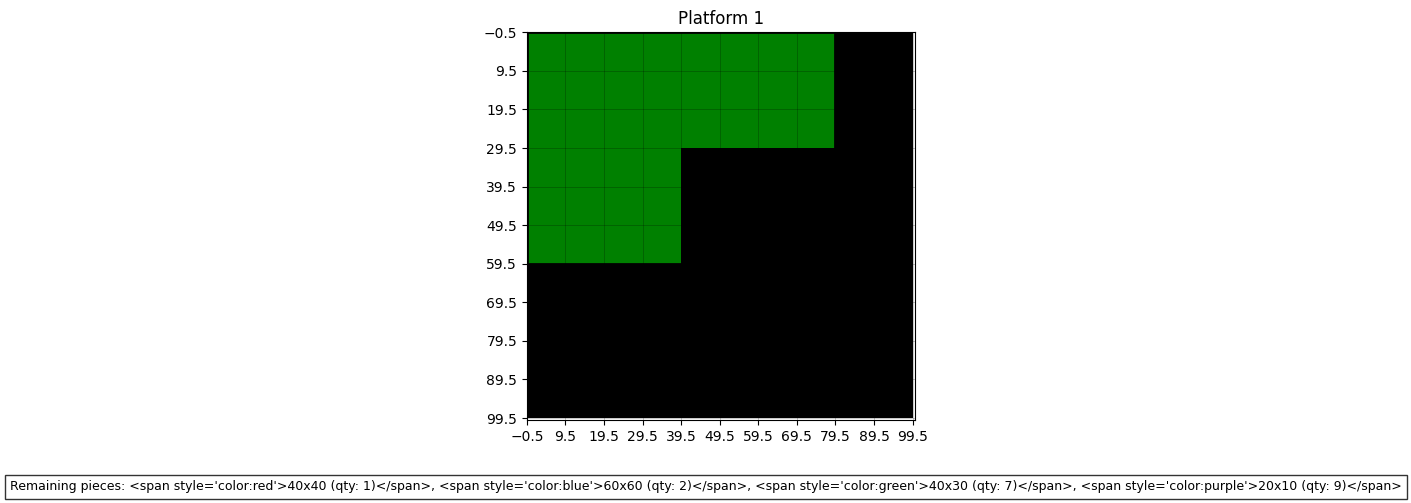

current_step:  4


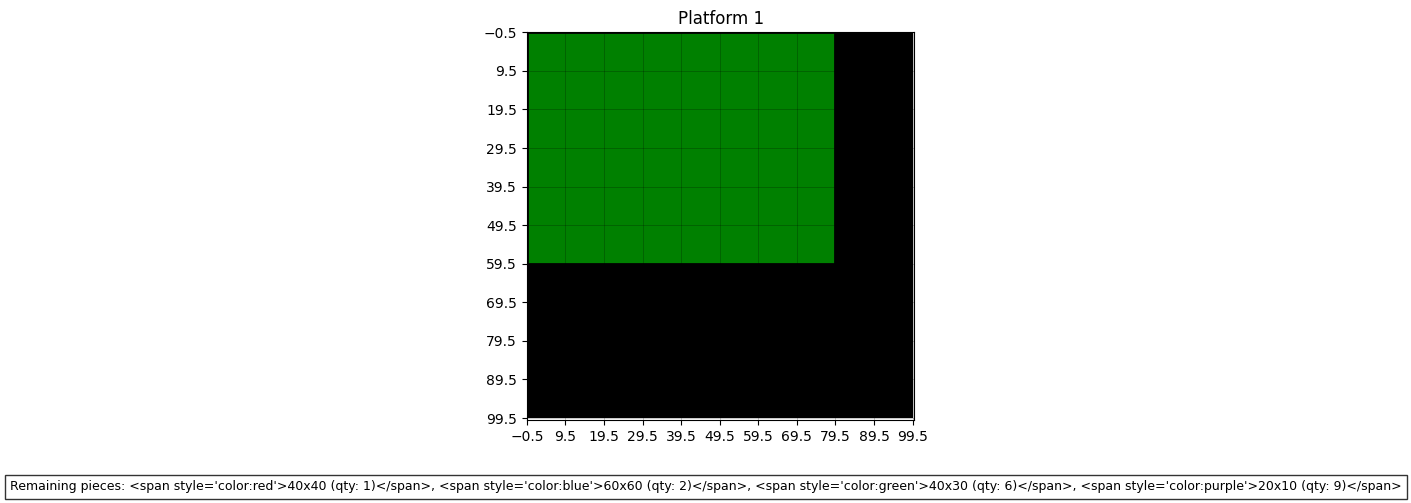

current_step:  5


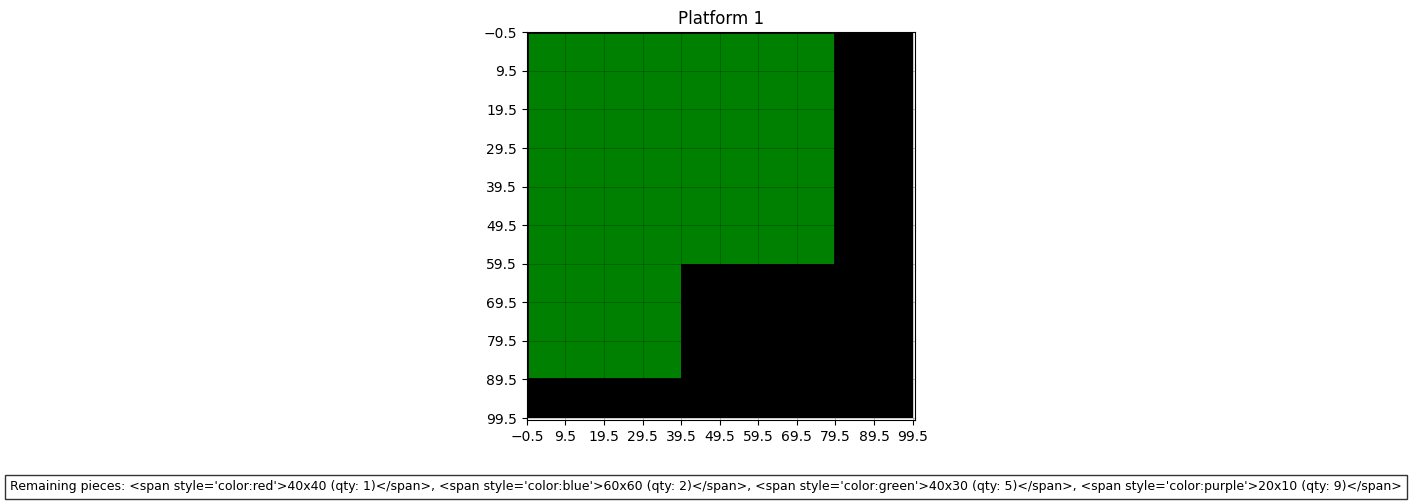

current_step:  6


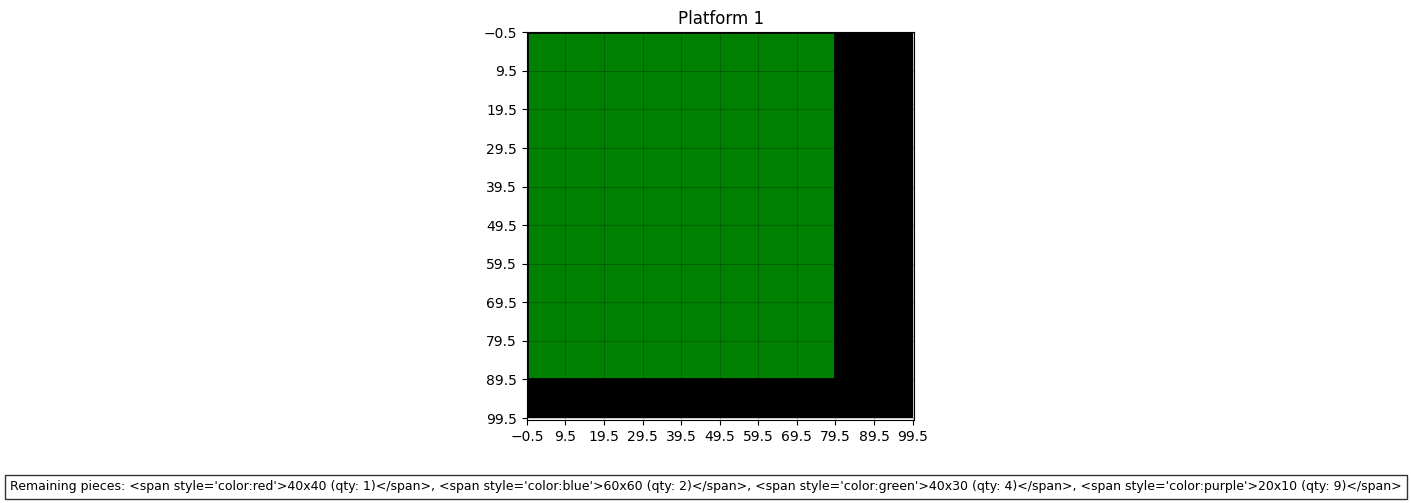

current_step:  7


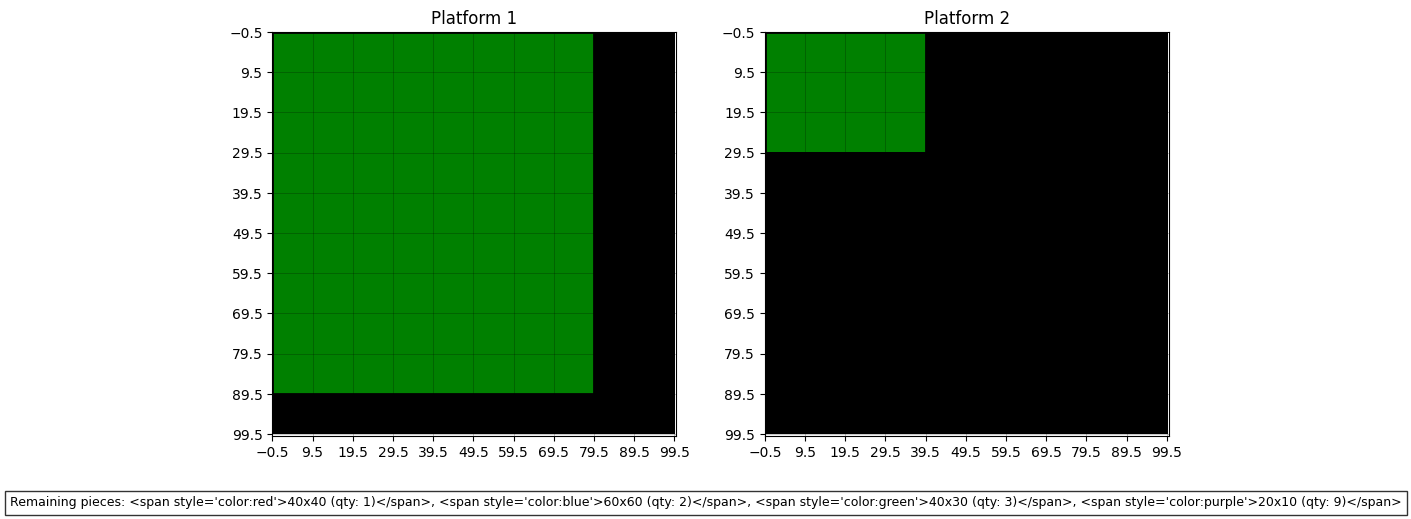

current_step:  8


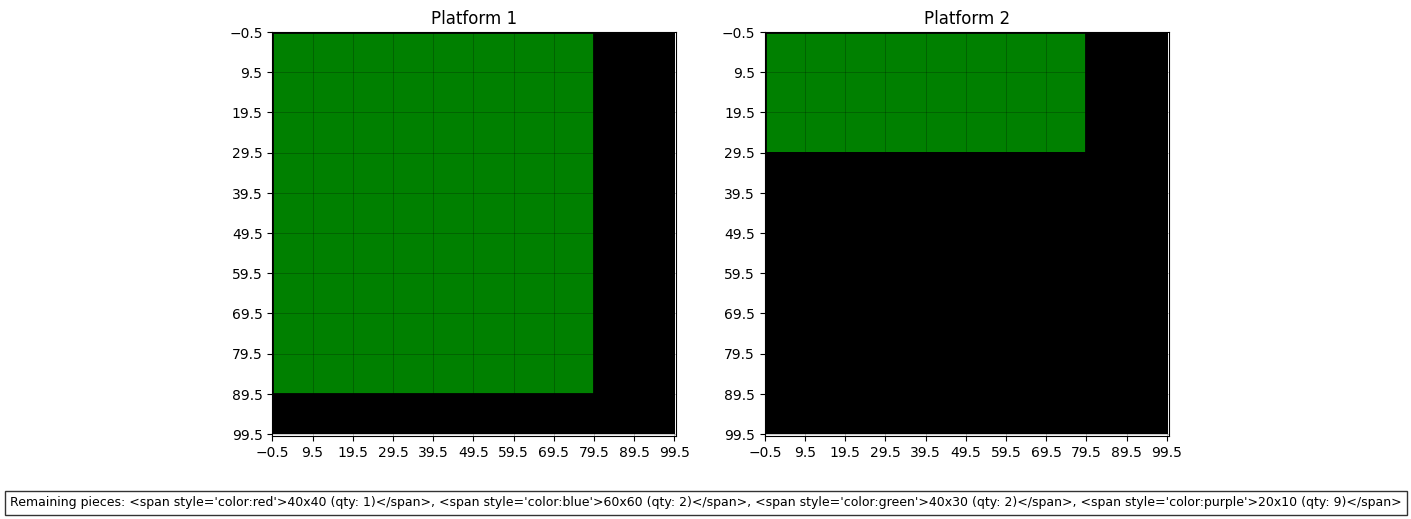

current_step:  9


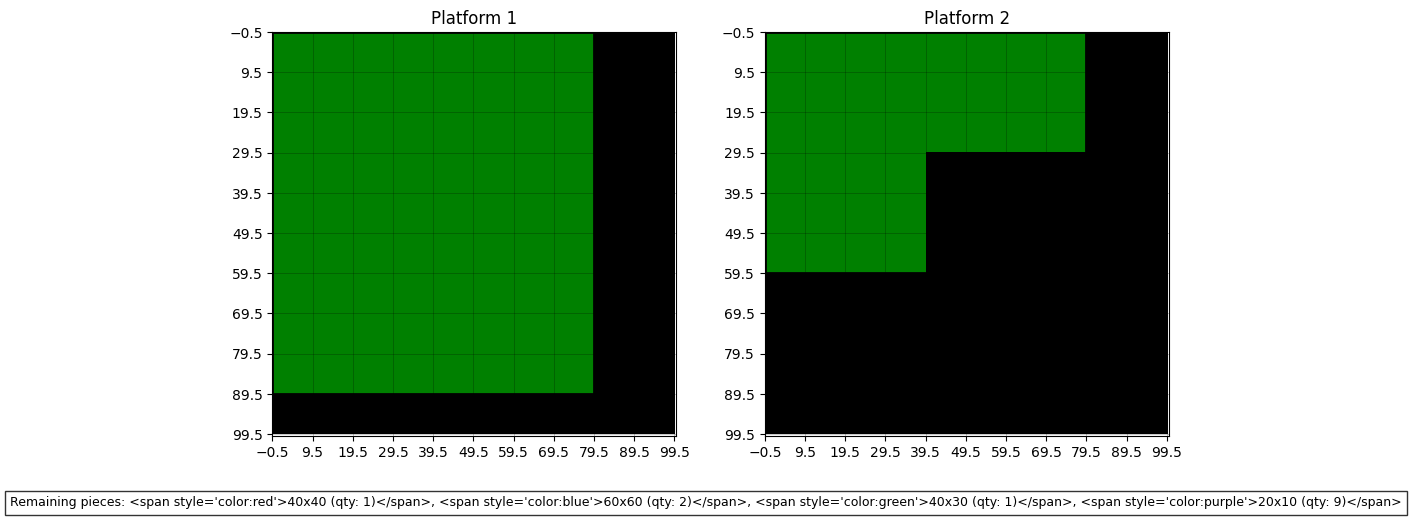

current_step:  10


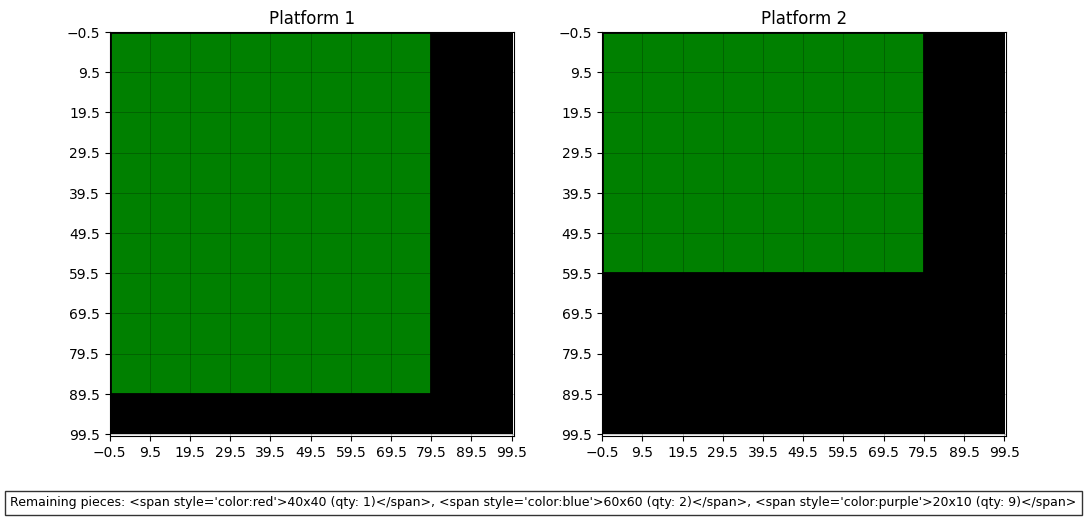

current_step:  11


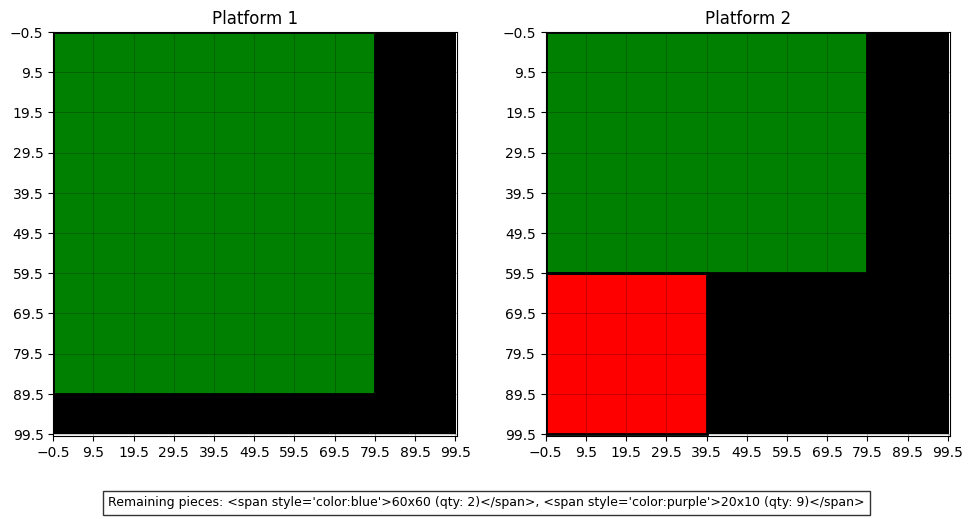

current_step:  12


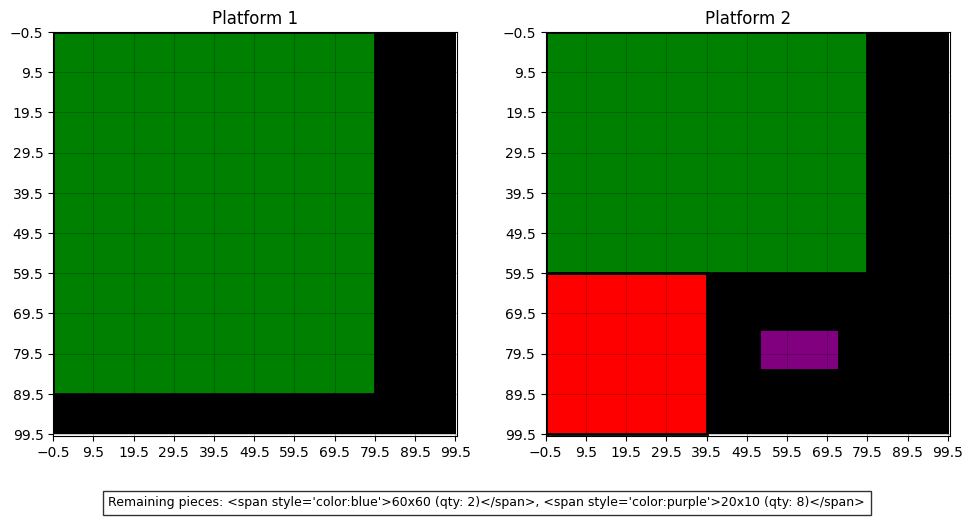

current_step:  13


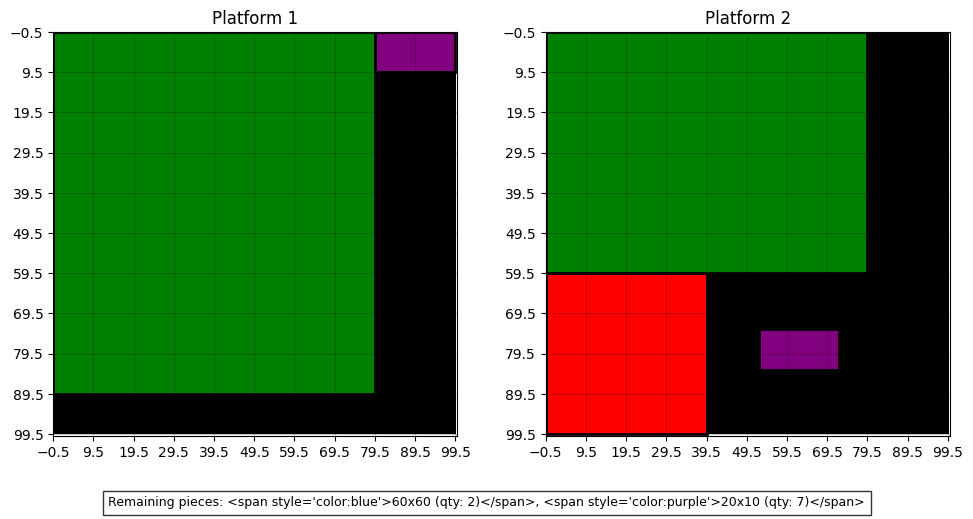

current_step:  14


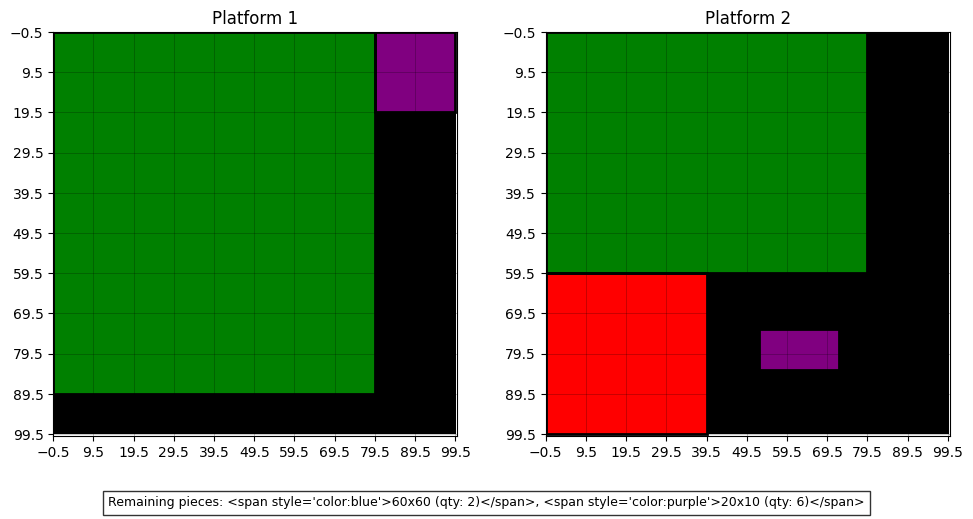

current_step:  15


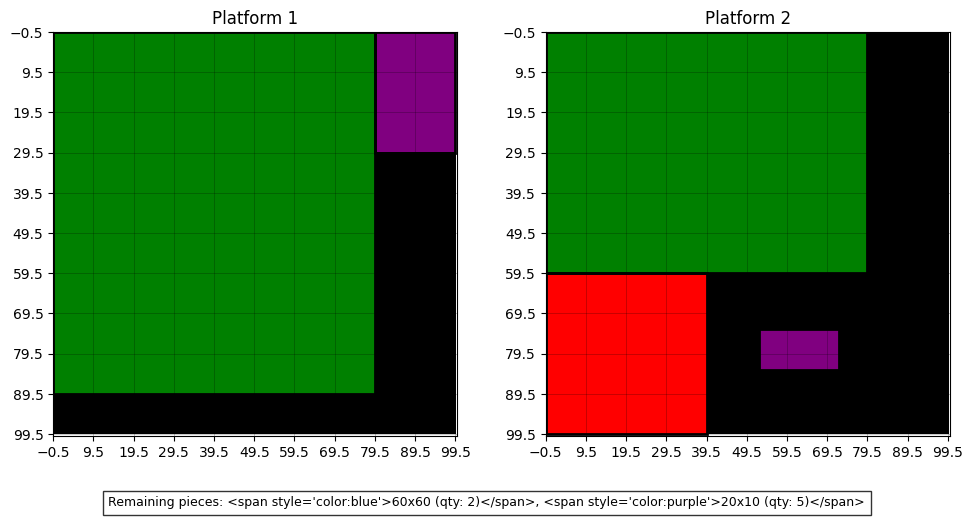

current_step:  16


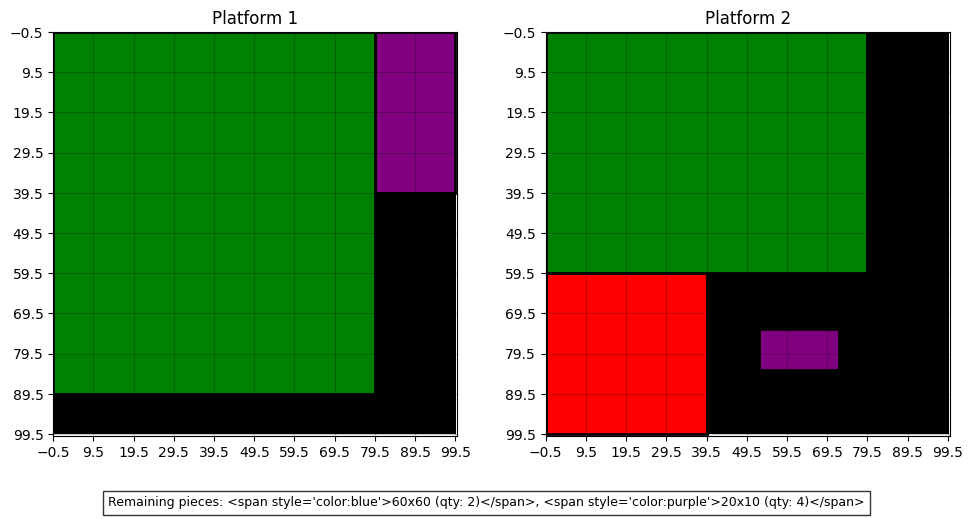

current_step:  17


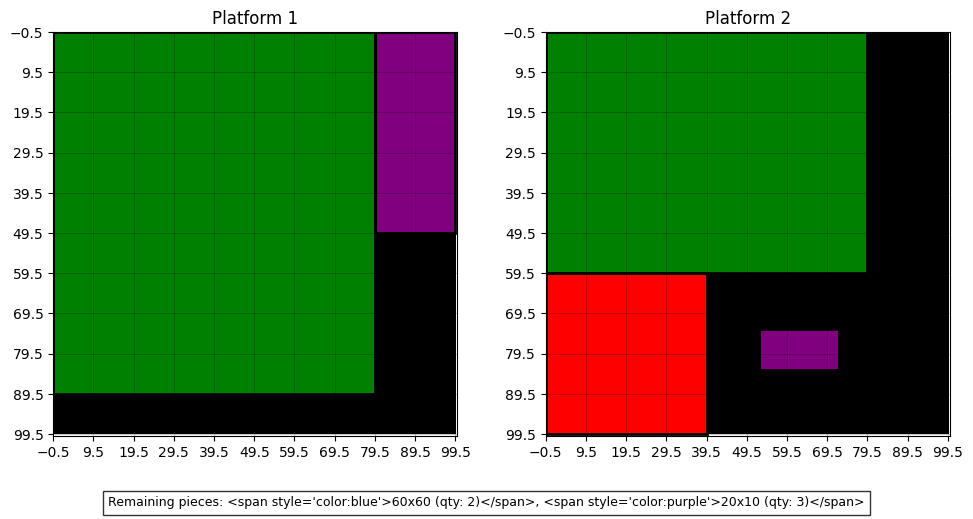

current_step:  18


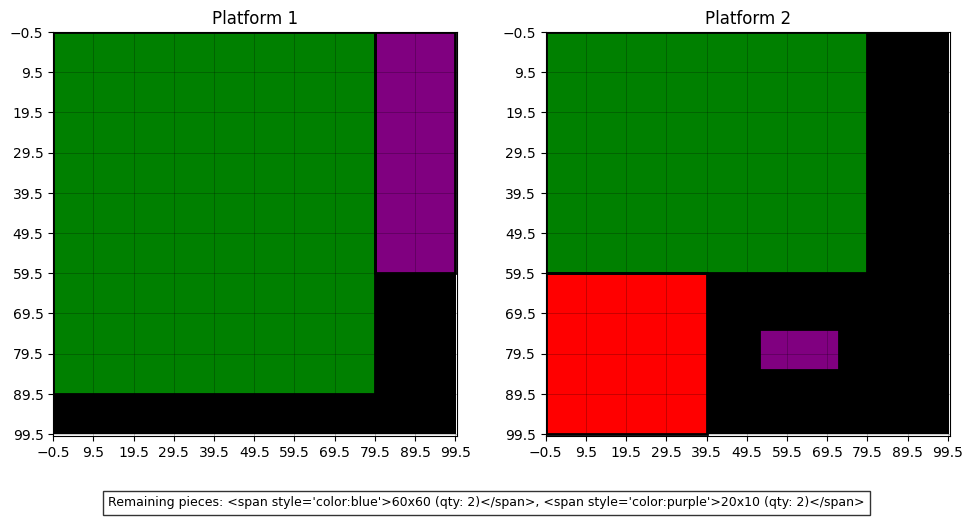

current_step:  19


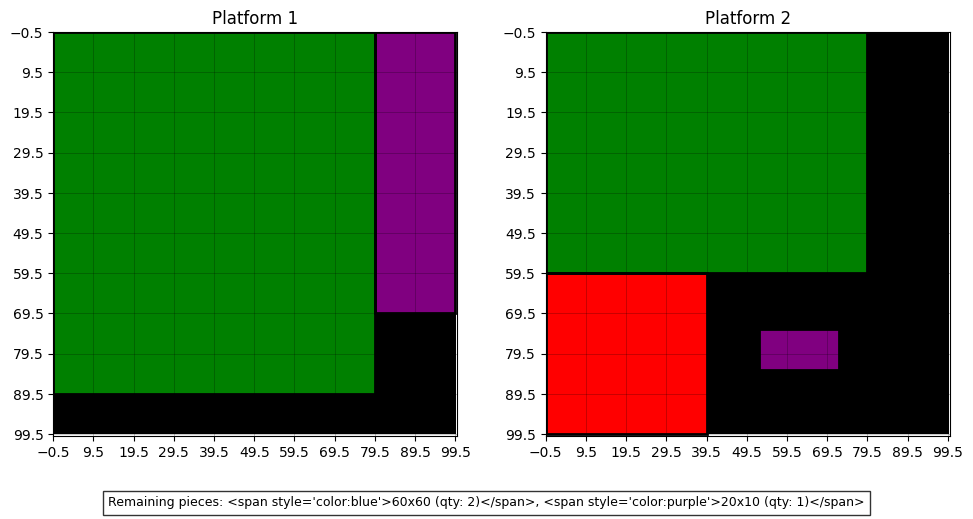

current_step:  20


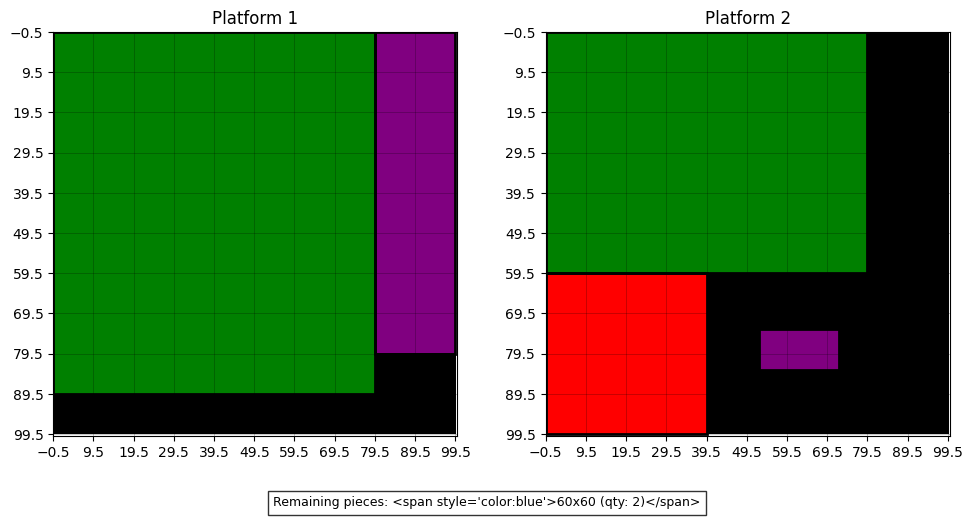

current_step:  21


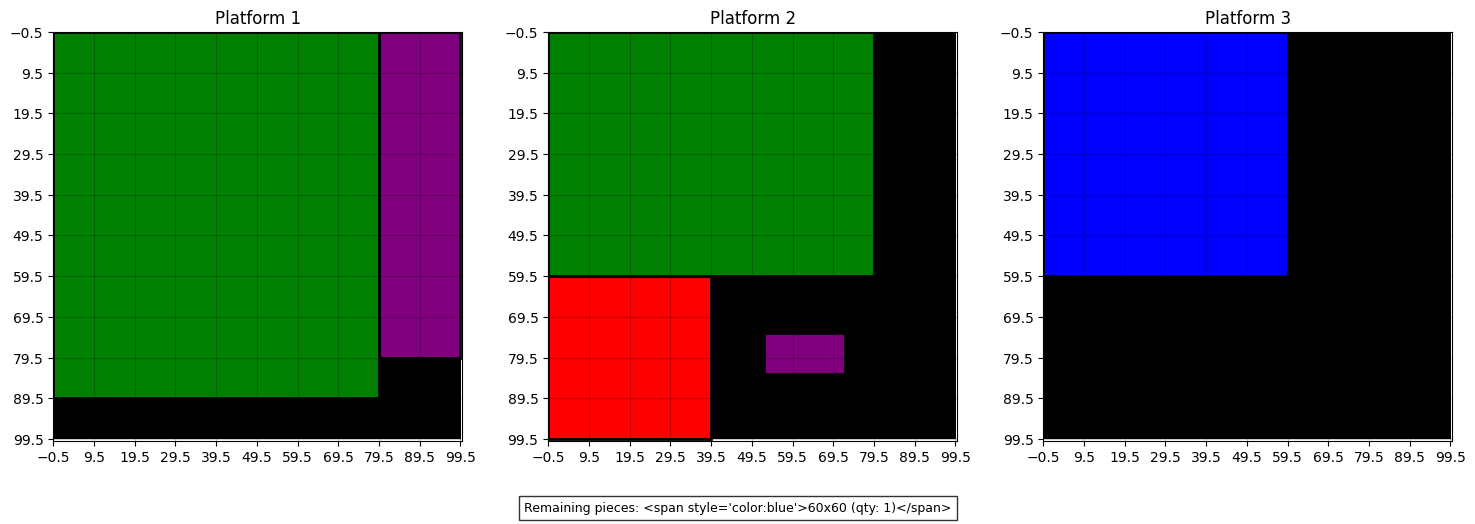

current_step:  22


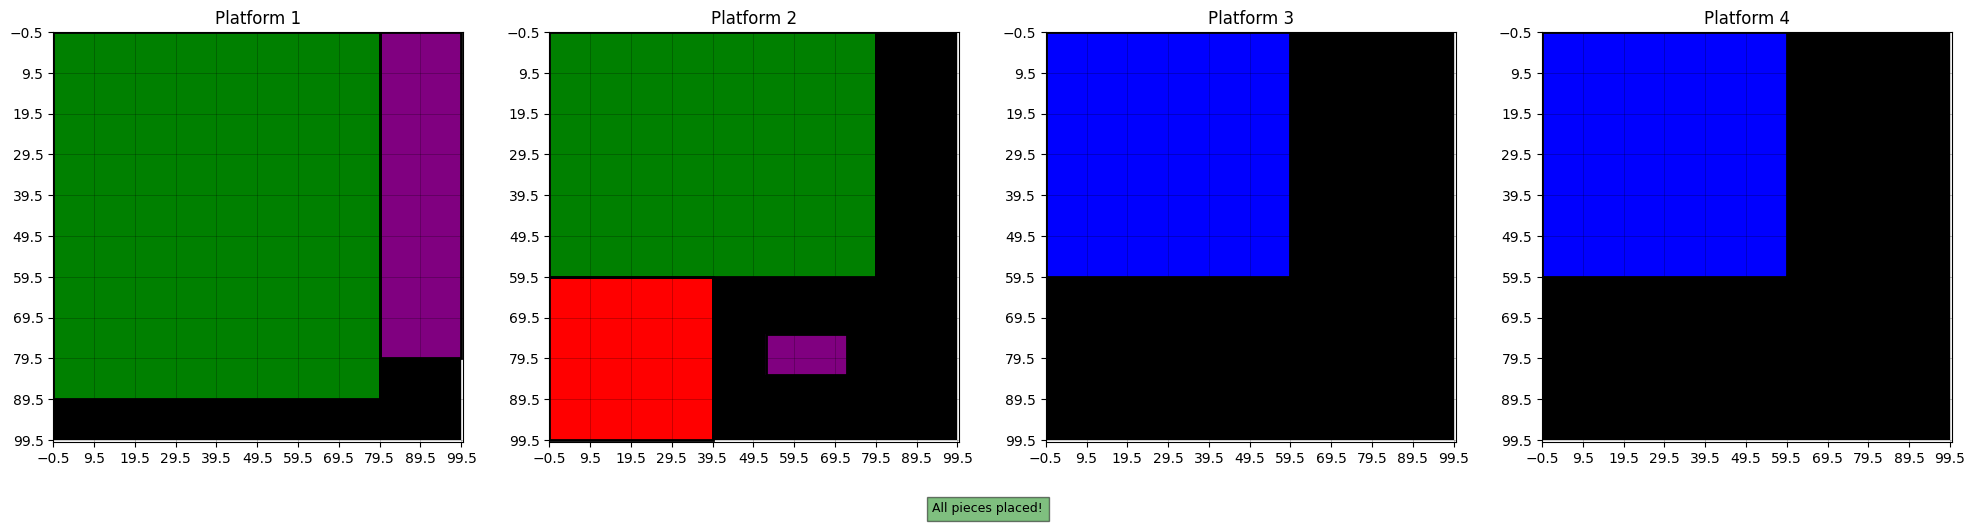

Order completed in 22 steps
Total reward: 22925.00
Waste: 17400
Efficiency: 0.56
Platforms used: 4
current_step:  22


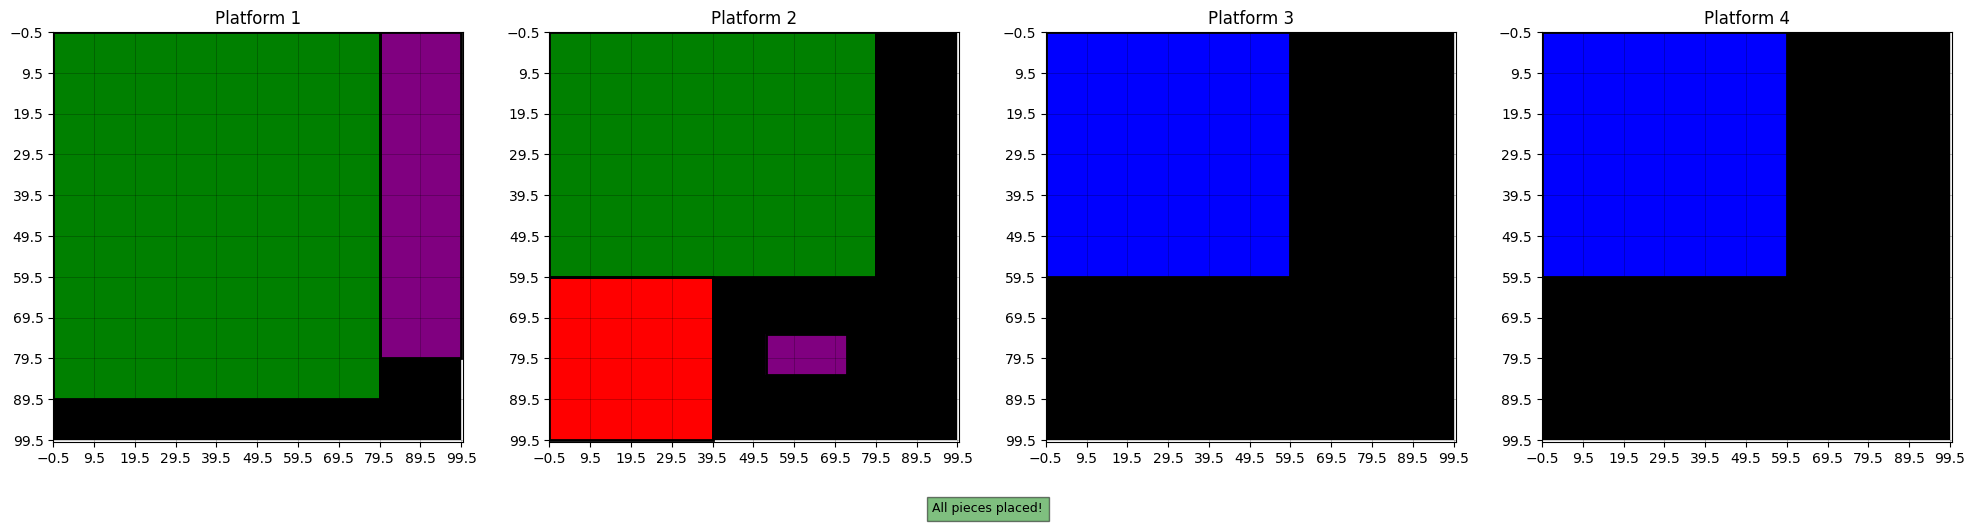

np.float64(22925.0)

In [7]:
custom_order_example()